✅ Dataset Loaded. Shape: (11229, 16)
📌 Available Columns: ['datetime', 'longitude', 'latitude', 'uhi_index', 'land_surface_temp', 'band1', 'band2', 'band3', 'band4', 'air_temp_at_surface_', 'relative_humidity_', 'avg_wind_speed_', 'wind_direction_', 'solar_flux_', 'nearest_building_lon', 'nearest_building_lat']
✅ Removed Prohibited Features.
✅ Extracted Temporal Features: 'hour', 'weekday', 'month'
✅ Created hour_category and is_weekend features.
✅ Using 'air_temp_at_surface_' for air temperature, 'relative_humidity_' for humidity, and 'avg_wind_speed_' for wind speed calculations.
✅ Computed NDVI, NDBI, and Surface Albedo.
✅ Standardized Satellite Data.
✅ Feature Engineered Dataset Saved: ../data/processed/UHI_Weather_Building_Sentinel_LST_Featured_Cleaned.csv
📌 Final Column Names: ['datetime', 'uhi_index', 'land_surface_temp', 'band1', 'band2', 'band3', 'band4', 'air_temp_at_surface_', 'relative_humidity_', 'avg_wind_speed_', 'wind_direction_', 'solar_flux_', 'nearest_building_lon', 

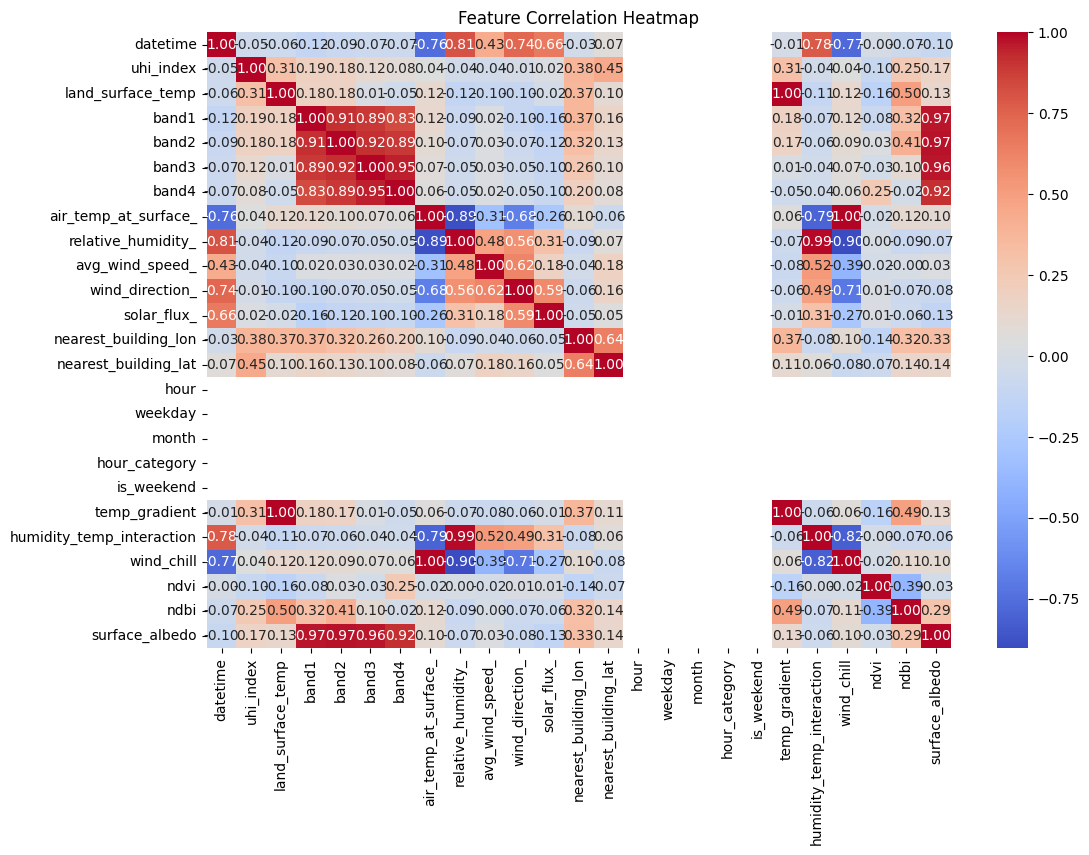

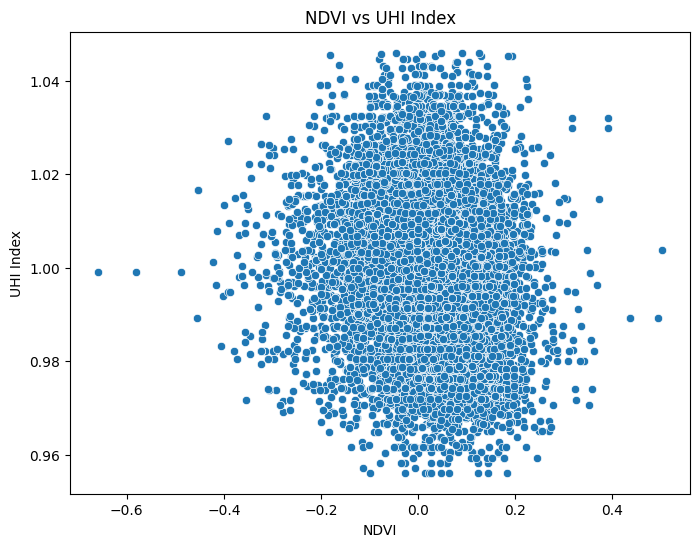

In [25]:
# 📌 Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# ----------------- 1️⃣ Load Data -----------------
data_path = "../data/processed/UHI_Weather_Building_Sentinel_LST_Merged.csv"
df = pd.read_csv(data_path)
print(f"✅ Dataset Loaded. Shape: {df.shape}")

# ✅ Standardize Column Names
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
print("📌 Available Columns:", df.columns.tolist())

# ----------------- 2️⃣ Remove Prohibited Features -----------------
# ❌ Remove longitude, latitude, and derived distance metrics
prohibited_cols = ["longitude", "latitude", "building_distance_m"]
df.drop(columns=[col for col in prohibited_cols if col in df.columns], errors="ignore", inplace=True)
print("✅ Removed Prohibited Features.")

# ----------------- 3️⃣ Temporal Feature Engineering -----------------
# ✅ Ensure datetime column exists
if "datetime" in df.columns:
    df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce")
    df["hour"] = df["datetime"].dt.hour
    df["weekday"] = df["datetime"].dt.weekday  # Monday = 0, Sunday = 6
    df["month"] = df["datetime"].dt.month
    print("✅ Extracted Temporal Features: 'hour', 'weekday', 'month'")
else:
    print("❌ 'datetime' column missing; skipping temporal features.")

# ✅ Hour Categorization
df["hour_category"] = pd.cut(
    df["hour"], bins=[0, 6, 12, 18, 24], labels=["Night", "Morning", "Afternoon", "Evening"], include_lowest=True
)

# ✅ Weekday vs Weekend
df["is_weekend"] = df["weekday"].apply(lambda x: 1 if x >= 5 else 0)
print("✅ Created hour_category and is_weekend features.")

# ----------------- 4️⃣ Weather Feature Engineering -----------------
# ✅ Dynamically Find Correct Column Names
air_temp_col = [col for col in df.columns if "air_temp" in col.lower()]
humidity_col = [col for col in df.columns if "humidity" in col.lower()]
wind_speed_col = [col for col in df.columns if "wind_speed" in col.lower()]

# ✅ Perform Weather Feature Calculations
if air_temp_col and humidity_col and wind_speed_col:
    df["temp_gradient"] = df["land_surface_temp"] - df[air_temp_col[0]]
    df["humidity_temp_interaction"] = df[humidity_col[0]] * df[air_temp_col[0]]
    df["wind_chill"] = (13.12 + 0.6215 * df[air_temp_col[0]] -
                        11.37 * (df[wind_speed_col[0]] ** 0.16) +
                        0.3965 * df[air_temp_col[0]] * (df[wind_speed_col[0]] ** 0.16))
    
    print(f"✅ Using '{air_temp_col[0]}' for air temperature, '{humidity_col[0]}' for humidity, and '{wind_speed_col[0]}' for wind speed calculations.")
else:
    missing = []
    if not air_temp_col:
        missing.append("Air Temperature")
    if not humidity_col:
        missing.append("Relative Humidity")
    if not wind_speed_col:
        missing.append("Wind Speed")
    
    raise KeyError(f"❌ Missing required columns: {missing}. Available columns: {df.columns.tolist()}")

# ----------------- 5️⃣ Satellite Feature Engineering -----------------
# ✅ Normalized Difference Vegetation Index (NDVI)
df["ndvi"] = (df["band4"] - df["band3"]) / (df["band4"] + df["band3"] + 1e-6)  # Avoid division by zero

# ✅ Normalized Difference Built-Up Index (NDBI)
df["ndbi"] = (df["band2"] - df["band4"]) / (df["band2"] + df["band4"] + 1e-6)

# ✅ Surface Albedo Approximation
df["surface_albedo"] = df[["band1", "band2", "band3"]].mean(axis=1) / 10000  # Normalize reflectance

print("✅ Computed NDVI, NDBI, and Surface Albedo.")

# ----------------- 6️⃣ Standardize Features -----------------
scaler = StandardScaler()
scaled_cols = ["land_surface_temp", "band1", "band2", "band3", "band4"]
df[scaled_cols] = scaler.fit_transform(df[scaled_cols])
print("✅ Standardized Satellite Data.")

# ----------------- 7️⃣ Save Processed Dataset -----------------
feature_engineered_path = "../data/processed/UHI_Weather_Building_Sentinel_LST_Featured_Cleaned.csv"
df.to_csv(feature_engineered_path, index=False)
print(f"✅ Feature Engineered Dataset Saved: {feature_engineered_path}")
print("📌 Final Column Names:", df.columns.tolist())

# ----------------- 🔍 8️⃣ Visualizations -----------------
# ✅ Correlation Heatmap
plt.figure(figsize=(12, 8))
hour_category_map = {"Night": 0, "Morning": 1, "Afternoon": 2, "Evening": 3}
df["hour_category"] = df["hour_category"].map(hour_category_map)
df["is_weekend"] = df["is_weekend"].astype(int)

sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

# ✅ Scatter Plot: NDVI vs UHI Index
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df["ndvi"], y=df["uhi_index"])
plt.title("NDVI vs UHI Index")
plt.xlabel("NDVI")
plt.ylabel("UHI Index")
plt.show()

In [26]:
df.dtypes

datetime                     datetime64[ns]
uhi_index                           float64
land_surface_temp                   float64
band1                               float64
band2                               float64
band3                               float64
band4                               float64
air_temp_at_surface_                float64
relative_humidity_                  float64
avg_wind_speed_                     float64
wind_direction_                     float64
solar_flux_                         float64
nearest_building_lon                float64
nearest_building_lat                float64
hour                                  int32
weekday                               int32
month                                 int32
hour_category                      category
is_weekend                            int64
temp_gradient                       float64
humidity_temp_interaction           float64
wind_chill                          float64
ndvi                            

In [27]:
df.isnull().sum()

datetime                     0
uhi_index                    0
land_surface_temp            0
band1                        0
band2                        0
band3                        0
band4                        0
air_temp_at_surface_         0
relative_humidity_           0
avg_wind_speed_              0
wind_direction_              0
solar_flux_                  0
nearest_building_lon         0
nearest_building_lat         0
hour                         0
weekday                      0
month                        0
hour_category                0
is_weekend                   0
temp_gradient                0
humidity_temp_interaction    0
wind_chill                   0
ndvi                         0
ndbi                         0
surface_albedo               0
dtype: int64